# Sentiment Analysis

In [1]:
'''The goal of this project is to perform sentiment analysis on tweets 
about US airlines using machine learning algorithms. The project uses 
a dataset containing tweets from Twitter users about their experiences 
with different airlines.'''

#IMPORTS
import pandas as pd
import numpy as np
import re
# from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from string import punctuation

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.metrics import accuracy_score
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

In [2]:
#Reading the training and testing data
train=pd.read_csv("training_twitter_x_y_train.csv") 
test = pd.read_csv("test_twitter_x_test.csv")

In [3]:
#Analysing the data
print(train.shape)
print(test.shape)

(10980, 12)
(3660, 11)


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10980 entries, 0 to 10979
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   tweet_id                10980 non-null  float64
 1   airline_sentiment       10980 non-null  object 
 2   airline                 10980 non-null  object 
 3   airline_sentiment_gold  31 non-null     object 
 4   name                    10980 non-null  object 
 5   negativereason_gold     24 non-null     object 
 6   retweet_count           10980 non-null  int64  
 7   text                    10980 non-null  object 
 8   tweet_coord             776 non-null    object 
 9   tweet_created           10980 non-null  object 
 10  tweet_location          7430 non-null   object 
 11  user_timezone           7403 non-null   object 
dtypes: float64(1), int64(1), object(10)
memory usage: 1.0+ MB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3660 entries, 0 to 3659
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   tweet_id                3660 non-null   int64 
 1   airline                 3660 non-null   object
 2   airline_sentiment_gold  9 non-null      object
 3   name                    3660 non-null   object
 4   negativereason_gold     8 non-null      object
 5   retweet_count           3660 non-null   int64 
 6   text                    3660 non-null   object
 7   tweet_coord             243 non-null    object
 8   tweet_created           3660 non-null   object
 9   tweet_location          2477 non-null   object
 10  user_timezone           2417 non-null   object
dtypes: int64(2), object(9)
memory usage: 314.7+ KB


In [6]:
# Checking the various reasons for negative comments
print(train['negativereason_gold'].nunique())
print(train['negativereason_gold'].value_counts(),"\n")

print(test.negativereason_gold.nunique())
print(test.negativereason_gold.value_counts())

11
Customer Service Issue                      9
Late Flight                                 3
Cancelled Flight                            3
Can't Tell                                  2
Late Flight\nFlight Attendant Complaints    1
Cancelled Flight\nCustomer Service Issue    1
Late Flight\nCancelled Flight               1
Customer Service Issue\nLost Luggage        1
Customer Service Issue\nCan't Tell          1
Bad Flight                                  1
Lost Luggage\nDamaged Luggage               1
Name: negativereason_gold, dtype: int64 

6
Customer Service Issue                      3
Flight Attendant Complaints                 1
Late Flight                                 1
Late Flight\nLost Luggage                   1
Cancelled Flight\nCustomer Service Issue    1
Can't Tell                                  1
Name: negativereason_gold, dtype: int64


In [7]:
train.head()

,tweet_id,airline_sentiment,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,5.679000e+17,negative,Southwest,NaN,ColeyGirouard,NaN,0,"@SouthwestAir I am scheduled for the morning, ...",NaN,2015-02-17 20:16:29 -0800,Washington D.C.,Atlantic Time (Canada)
1,5.699890e+17,positive,Southwest,NaN,WalterFaddoul,NaN,0,@SouthwestAir seeing your workers time in and ...,NaN,2015-02-23 14:36:22 -0800,"Indianapolis, Indiana; USA",Central Time (US & Canada)
2,5.680890e+17,positive,United,NaN,LocalKyle,NaN,0,@united Flew ORD to Miami and back and had gr...,NaN,2015-02-18 08:46:29 -0800,Illinois,Central Time (US & Canada)
3,5.689280e+17,negative,Southwest,NaN,amccarthy19,NaN,0,@SouthwestAir @dultch97 that's horse radish 😤🐴,NaN,2015-02-20 16:20:26 -0800,NaN,Atlantic Time (Canada)
4,5.685940e+17,negative,United,NaN,J_Okayy,NaN,0,@united so our flight into ORD was delayed bec...,NaN,2015-02-19 18:13:11 -0800,NaN,Eastern Time (US & Canada)


In [8]:
#Types of sentiments
train["airline_sentiment"].unique()

array(['negative', 'positive', 'neutral'], dtype=object)

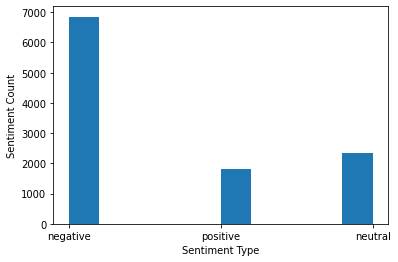

In [9]:
#Plotting sentiment counts in training data
plt.xlabel("Sentiment Type")
plt.ylabel("Sentiment Count")
plt.hist(train["airline_sentiment"])
plt.show()

## Cleaning

In [10]:
#Cleaning and transforming raw data prior to processing and analysis.

In [11]:
'''Several columns, such as "airline_sentiment_gold","name","tweet_id"
,"retweet_count","tweet_created","user_timezone","tweet_coord", and 
"tweet_location", are not useful for our analysis, so we dropped them 
from both the training and test datasets.'''
drop_cols = ['airline_sentiment_gold','name','tweet_id', 'retweet_count',
             'tweet_created','user_timezone','tweet_coord','tweet_location']
train.drop(drop_cols, axis = 1, inplace=True)
test.drop(drop_cols, axis = 1, inplace=True)

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10980 entries, 0 to 10979
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   airline_sentiment    10980 non-null  object
 1   airline              10980 non-null  object
 2   negativereason_gold  24 non-null     object
 3   text                 10980 non-null  object
dtypes: object(4)
memory usage: 343.2+ KB


In [13]:
#Make a list of stopwords in english
stops = stopwords.words('english')
stops += list(punctuation)
stops += ['flight','airline','flights','AA']
print(stops)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [14]:
#Substituting for abbreviations used in comments
abbreviations = {'ppl': 'people','cust':'customer','serv':'service',
                 'mins':'minutes','hrs':'hours','svc': 'service',
                'u':'you','pls':'please'}

#Getting the indices where negative reason is not null
train_index = train[~train.negativereason_gold.isna()].index
test_index = test[~test.negativereason_gold.isna()].index

'''Removing all links, usernames, white spaces,#tags, replacing 
abbreviations with actual words from the comments of training data'''

for index, row in train.iterrows():
    tweet = row.text
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','',tweet) #remove links
    tweet = re.sub('@[^\s]+','',tweet) #remove usernames
    tweet = re.sub('[\s]+', ' ', tweet) #remove additional whitespaces
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet) #replace #word with word
    tweet = tweet.strip('\'"') #trim tweet
    words = []
    for word in tweet.split():
        if word.lower() not in stops:
            if word in list(abbreviations.keys()):
                words.append(abbreviations[word])
            else:
                words.append(word.lower())   
    tweet = " ".join(words)
    tweet = " %s %s" % (tweet, row.airline)
    row.text = tweet
    if index in train_index:
        row.text = " %s %s" % (row.text, row.negativereason_gold)

'''Removing all links,usernames,white spaces, #tags, replacing 
abbreviations with actual words from the comments from testing data'''

for index, row in test.iterrows():
    tweet = row.text
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','',tweet) #remove links
    tweet = re.sub('@[^\s]+','',tweet) #remove usernames
    tweet = re.sub('[\s]+', ' ', tweet) #remove additional whitespaces
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet) #replace #word with word
    tweet = tweet.strip('\'"') #trim tweet
    words = []
    for word in tweet.split(): 
#         if not hasNumbers(word):
        if word.lower() not in stops:
            if word in list(abbreviations.keys()):
                words.append(abbreviations[word])
            else:
                words.append(word.lower())
    tweet = " ".join(words)
    tweet = " %s %s" % (tweet, row.airline)
    row.text = tweet
    if index in test_index:
        row.text = " %s %s" % (row.text, row.negativereason_gold)

del train['negativereason_gold']
del test['negativereason_gold']

In [15]:
#Removing the emojies from the comments in training and testing data
def deEmojify(inputString):
    return inputString.encode('ascii', 'ignore').decode('ascii')

for index, row in train.iterrows():
    row.text = deEmojify(row.text)

for index, row in test.iterrows():
    row.text = deEmojify(row.text)

In [16]:
#Removing the numbers from the comments of traing and testing data
def hasNumbers(inputString):
    return any(char.isdigit() for char in inputString)

for index, row in train.iterrows():
    words = row.text.split()
    new_words = []
    for word in words:
        if not hasNumbers(word):
            new_words.append(word)
    row.text = " ".join(new_words)
    
for index, row in test.iterrows():
    words = row.text.split()
    new_words = []
    for word in words:
        if not hasNumbers(word):
            new_words.append(word)
    row.text = " ".join(new_words)

## Creating vocab and data formatting

In [17]:
'''Getting vocab of all words in comments of training and testing data
TfidfVectorizer creates a matrix of term frequency-inverse document frequency
(TF-IDF) values.'''
v = TfidfVectorizer()
train_features= v.fit_transform(train.text)
test_features=v.transform(test.text)
#print(v.get_feature_names_out())

In [18]:
#Making predictions using Logistic regression
clf = LogisticRegression(C = 2.1, solver='liblinear',multi_class='auto')
clf.fit(train_features,train['airline_sentiment'])
pred = clf.predict(test_features)
pred2=clf.predict(train_features)

#Writing predictions into file predictions_twitter.csv
with open('predictions_twitter.csv', 'w') as f:
    for item in pred:
        f.write("%s\n" % item)

acc = accuracy_score(train["airline_sentiment"], pred2)
print("Accuracy in training data :",acc)
print(metrics.classification_report(train["airline_sentiment"], pred2))

Accuracy in training data : 0.8842440801457195
              precision    recall  f1-score   support

    negative       0.88      0.98      0.93      6851
     neutral       0.88      0.69      0.77      2327
    positive       0.91      0.78      0.84      1802

    accuracy                           0.88     10980
   macro avg       0.89      0.81      0.85     10980
weighted avg       0.89      0.88      0.88     10980



In [19]:
#Making predictions using Support vector machine
clf = SVC(kernel="linear", C= 0.96)
clf.fit(train_features, train['airline_sentiment'])
pred = clf.predict(test_features)
pred2=clf.predict(train_features)

#Writing predictions into file predictions_twitter2.csv
with open('predictions_twitter2.csv', 'w') as f:
    for item in pred:
        f.write("%s\n" % item)
        
acc = accuracy_score(train["airline_sentiment"], pred2)
print("Accuracy in testing data :",acc)
print(metrics.classification_report(train["airline_sentiment"], pred2))

Accuracy in testing data : 0.8970856102003643
              precision    recall  f1-score   support

    negative       0.90      0.98      0.94      6851
     neutral       0.88      0.72      0.79      2327
    positive       0.91      0.82      0.86      1802

    accuracy                           0.90     10980
   macro avg       0.90      0.84      0.86     10980
weighted avg       0.90      0.90      0.89     10980



# VISUALIZE THE RESULTS

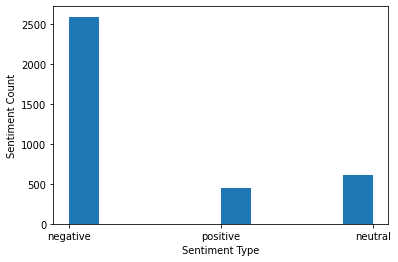

In [20]:
#Plotting sentiment counts in testing data
plt.xlabel("Sentiment Type")
plt.ylabel("Sentiment Count")
plt.hist(pred)
plt.show()

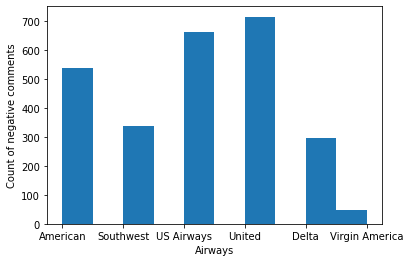

In [21]:
#plot count of negative comments for different airlines
airways=[]
for i in range(len(pred)):
    if pred[i]=="negative":
        airways.append(test.iloc[i,0])
plt.hist(airways)
plt.xlabel("Airways")
plt.ylabel("Count of negative comments")
plt.show()

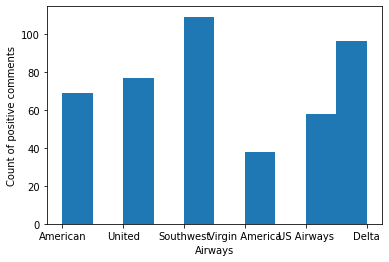

In [22]:
#plot count of positive comments for different airlines
airways=[]
for i in range(len(pred)):
    if pred[i]=="positive":
        airways.append(test.iloc[i,0])
plt.hist(airways)
plt.xlabel("Airways")
plt.ylabel("Count of positive comments")
plt.show()